Notebook to further evaluate the results of a HDBSCAN clustering output, but more specifically the clustering that doesn't make use of UMAP dimensionality reduction. 

This notebook is meant to be utilised to build better visualisations to understand how the data is being clustered, understand quality evaluation metrics better etc.

In [12]:
# Import required libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import silhouette_samples
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


In [13]:
# Load the clustering results from flexible pipeline and original data
# Note: Using flexible pipeline results which respects the config UMAP setting (disabled)
try:
    clustered_data = pd.read_csv('/Users/tomdavey/Documents/GitHub/MLProject1/clustering_output/flexible_pipeline/hdbscan_results/clustered_data.csv')
    cluster_labels = pd.read_csv('/Users/tomdavey/Documents/GitHub/MLProject1/clustering_output/flexible_pipeline/hdbscan_results/cluster_labels.csv')
    
    # Check if clustered_data has actual feature values
    feature_columns = [col for col in clustered_data.columns if col != 'cluster_label']
    has_feature_data = not clustered_data[feature_columns].isna().all().all()
    
    if has_feature_data:
        print("✅ Successfully loaded flexible pipeline results with feature data")
        data_source = "flexible_pipeline"
    else:
        print("⚠️  Flexible pipeline data missing feature values, using original data with cluster labels")
        # Use original data but with flexible pipeline cluster labels
        original_data = pd.read_csv('/Users/tomdavey/Documents/GitHub/MLProject1/data/processed_data/AS_1_feature_data.csv')
        
        # Get the subset of data that was clustered (first 20,174 rows to match cluster labels)
        n_clustered = len(cluster_labels)
        original_subset = original_data.iloc[:n_clustered].copy()
        
        # Apply the same preprocessing that would be used in flexible pipeline
        # (based on config: log transformation + standard scaling, excluding specific columns)
        from sklearn.preprocessing import StandardScaler
        import numpy as np
        
        # Exclude columns as per config
        exclude_cols = ['WALLET', 'TX_PER_MONTH', 'ACTIVE_DURATION_DAYS']
        numeric_cols = [col for col in original_subset.columns if col not in exclude_cols and original_subset[col].dtype in ['int64', 'float64']]
        
        # Log transformation (log1p for zero/negative handling)
        log_cols = [col for col in numeric_cols if col not in ['TX_PER_MONTH', 'ACTIVE_DURATION_DAYS']]
        preprocessed_data = original_subset[numeric_cols].copy()
        preprocessed_data[log_cols] = np.log1p(preprocessed_data[log_cols])
        
        # Standard scaling
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(preprocessed_data)
        
        # Create clustered_data DataFrame with scaled features
        clustered_data = pd.DataFrame(scaled_data, columns=[f'dim_{i}' for i in range(scaled_data.shape[1])])
        clustered_data['cluster_label'] = cluster_labels['cluster_label'].values
        
        print(f"✅ Created feature data from original data with flexible pipeline clustering")
        print(f"   Applied log transformation to {len(log_cols)} features")
        print(f"   Applied standard scaling to {len(numeric_cols)} features")
        data_source = "flexible_pipeline_reconstructed"
        
except Exception as e:
    print(f"⚠️  Error loading flexible pipeline data: {e}")
    print("Falling back to hdbscan_only results...")
    clustered_data = pd.read_csv('/Users/tomdavey/Documents/GitHub/MLProject1/clustering_output/hdbscan_only/clustered_data.csv')
    cluster_labels = pd.read_csv('/Users/tomdavey/Documents/GitHub/MLProject1/clustering_output/hdbscan_only/cluster_labels.csv')
    data_source = "hdbscan_only"

# Load original data for reference
original_data = pd.read_csv('/Users/tomdavey/Documents/GitHub/MLProject1/data/processed_data/AS_1_feature_data.csv')

print(f"\nData source: {data_source}")
print(f"Original data shape: {original_data.shape}")
print(f"Clustered data shape: {clustered_data.shape}")
print(f"Cluster labels shape: {cluster_labels.shape}")
print(f"\nUnique clusters: {sorted(clustered_data['cluster_label'].unique())}")
print(f"Cluster distribution:\n{clustered_data['cluster_label'].value_counts().sort_index()}")

⚠️  Flexible pipeline data missing feature values, using original data with cluster labels
✅ Created feature data from original data with flexible pipeline clustering
   Applied log transformation to 38 features
   Applied standard scaling to 38 features

Data source: flexible_pipeline_reconstructed
Original data shape: (50000, 41)
Clustered data shape: (20174, 39)
Cluster labels shape: (20174, 1)

Unique clusters: [np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
Cluster distribution:
cluster_label
-1    7859
 0     312
 1    1589
 2     512
 3     427
 4     139
 5     183
 6     113
 7    1119
 8    7921
Name: count, dtype: int64

Data source: flexible_pipeline_reconstructed
Original data shape: (50000, 41)
Clustered data shape: (20174, 39)
Cluster labels shape: (20174, 1)

Unique clusters: [np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int6

In [14]:
# Calculate comprehensive clustering quality metrics
def calculate_clustering_metrics(data, labels):
    """Calculate comprehensive clustering quality metrics"""
    
    # Remove noise points for some metrics
    non_noise_mask = labels != -1
    data_no_noise = data[non_noise_mask]
    labels_no_noise = labels[non_noise_mask]
    
    metrics = {}
    
    # Basic cluster statistics
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    n_noise = np.sum(labels == -1)
    
    metrics['n_clusters'] = n_clusters
    metrics['n_noise'] = n_noise
    metrics['noise_percentage'] = (n_noise / len(labels)) * 100
    metrics['total_points'] = len(labels)
    
    # Cluster sizes
    cluster_sizes = {}
    for label in unique_labels:
        if label != -1:
            cluster_sizes[f'cluster_{label}'] = np.sum(labels == label)
    metrics['cluster_sizes'] = cluster_sizes
    
    # Quality metrics (calculated without noise points)
    if len(np.unique(labels_no_noise)) > 1 and len(data_no_noise) > 0:
        metrics['silhouette_score'] = silhouette_score(data_no_noise, labels_no_noise)
        metrics['calinski_harabasz_score'] = calinski_harabasz_score(data_no_noise, labels_no_noise)
        metrics['davies_bouldin_score'] = davies_bouldin_score(data_no_noise, labels_no_noise)
    else:
        metrics['silhouette_score'] = None
        metrics['calinski_harabasz_score'] = None
        metrics['davies_bouldin_score'] = None
    
    return metrics

# Extract feature data (excluding cluster labels) - handle variable dimensions
feature_columns = [col for col in clustered_data.columns if col != 'cluster_label']
feature_data = clustered_data[feature_columns].values
labels = clustered_data['cluster_label'].values

print(f"Feature data shape: {feature_data.shape}")
print(f"Number of dimensions: {feature_data.shape[1]}")

# Calculate metrics
clustering_metrics = calculate_clustering_metrics(feature_data, labels)

print("HDBSCAN Clustering Quality Metrics (Flexible Pipeline):")
print("=" * 60)
print(f"Number of clusters: {clustering_metrics['n_clusters']}")
print(f"Number of noise points: {clustering_metrics['n_noise']}")
print(f"Total points: {clustering_metrics['total_points']}")
print(f"Noise percentage: {clustering_metrics['noise_percentage']:.2f}%")
print("\nCluster sizes:")
for cluster, size in clustering_metrics['cluster_sizes'].items():
    print(f"  {cluster}: {size} points")

print(f"\nQuality Metrics:")
if clustering_metrics['silhouette_score'] is not None:
    print(f"  Silhouette Score: {clustering_metrics['silhouette_score']:.4f}")
    print(f"  Calinski-Harabasz Score: {clustering_metrics['calinski_harabasz_score']:.2f}")
    print(f"  Davies-Bouldin Score: {clustering_metrics['davies_bouldin_score']:.4f}")
else:
    print("  Could not calculate quality metrics (insufficient clusters)")

Feature data shape: (20174, 38)
Number of dimensions: 38
HDBSCAN Clustering Quality Metrics (Flexible Pipeline):
Number of clusters: 9
Number of noise points: 7859
Total points: 20174
Noise percentage: 38.96%

Cluster sizes:
  cluster_0: 312 points
  cluster_1: 1589 points
  cluster_2: 512 points
  cluster_3: 427 points
  cluster_4: 139 points
  cluster_5: 183 points
  cluster_6: 113 points
  cluster_7: 1119 points
  cluster_8: 7921 points

Quality Metrics:
  Silhouette Score: -0.0556
  Calinski-Harabasz Score: 1.87
  Davies-Bouldin Score: 44.4763
HDBSCAN Clustering Quality Metrics (Flexible Pipeline):
Number of clusters: 9
Number of noise points: 7859
Total points: 20174
Noise percentage: 38.96%

Cluster sizes:
  cluster_0: 312 points
  cluster_1: 1589 points
  cluster_2: 512 points
  cluster_3: 427 points
  cluster_4: 139 points
  cluster_5: 183 points
  cluster_6: 113 points
  cluster_7: 1119 points
  cluster_8: 7921 points

Quality Metrics:
  Silhouette Score: -0.0556
  Calinski-Ha

In [15]:
# Create 3D visualization of clustering results
def create_3d_cluster_plot(data, labels, title="HDBSCAN Clustering Results (3D)"):
    """Create an interactive 3D scatter plot of clustering results"""
    
    # If data has more than 3 dimensions, use PCA to reduce to 3D for visualization
    if data.shape[1] > 3:
        print(f"Data has {data.shape[1]} dimensions, reducing to 3D using PCA for visualization...")
        pca_3d = PCA(n_components=3)
        data_3d = pca_3d.fit_transform(data)
        explained_var = pca_3d.explained_variance_ratio_
        print(f"PCA explained variance: {explained_var[0]:.3f}, {explained_var[1]:.3f}, {explained_var[2]:.3f}")
        print(f"Total variance explained: {explained_var.sum():.3f}")
        dim_labels = [f'PC1 ({explained_var[0]*100:.1f}%)', 
                     f'PC2 ({explained_var[1]*100:.1f}%)', 
                     f'PC3 ({explained_var[2]*100:.1f}%)']
    elif data.shape[1] == 3:
        data_3d = data
        dim_labels = ['Dimension 0', 'Dimension 1', 'Dimension 2']
    else:
        # If less than 3 dimensions, pad with zeros
        print(f"Data has only {data.shape[1]} dimensions, padding for 3D visualization...")
        data_3d = np.zeros((data.shape[0], 3))
        data_3d[:, :data.shape[1]] = data
        if data.shape[1] == 1:
            dim_labels = ['Dimension 0', 'Zero padding', 'Zero padding']
        else:  # data.shape[1] == 2
            dim_labels = ['Dimension 0', 'Dimension 1', 'Zero padding']
    
    # Create color mapping
    unique_labels = sorted(np.unique(labels))
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 
              'magenta', 'yellow', 'black', 'navy', 'lime', 'teal', 'silver', 'maroon']
    
    fig = go.Figure()
    
    for i, label in enumerate(unique_labels):
        mask = labels == label
        cluster_data_3d = data_3d[mask]
        
        if label == -1:
            # Noise points
            fig.add_trace(go.Scatter3d(
                x=cluster_data_3d[:, 0],
                y=cluster_data_3d[:, 1],
                z=cluster_data_3d[:, 2],
                mode='markers',
                marker=dict(
                    size=3,
                    color='black',
                    opacity=0.6
                ),
                name=f'Noise ({np.sum(mask)} points)',
                text=[f'Noise Point<br>{dim_labels[0]}: {x:.2f}<br>{dim_labels[1]}: {y:.2f}<br>{dim_labels[2]}: {z:.2f}' 
                      for x, y, z in cluster_data_3d]
            ))
        else:
            fig.add_trace(go.Scatter3d(
                x=cluster_data_3d[:, 0],
                y=cluster_data_3d[:, 1],
                z=cluster_data_3d[:, 2],
                mode='markers',
                marker=dict(
                    size=4,
                    color=colors[i % len(colors)],
                    opacity=0.7
                ),
                name=f'Cluster {label} ({np.sum(mask)} points)',
                text=[f'Cluster {label}<br>{dim_labels[0]}: {x:.2f}<br>{dim_labels[1]}: {y:.2f}<br>{dim_labels[2]}: {z:.2f}' 
                      for x, y, z in cluster_data_3d]
            ))
    
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title=dim_labels[0],
            yaxis_title=dim_labels[1],
            zaxis_title=dim_labels[2]
        ),
        width=900,
        height=700
    )
    
    return fig

# Create and display the 3D plot
fig_3d = create_3d_cluster_plot(feature_data, labels, "HDBSCAN Clustering Results - Flexible Pipeline")
fig_3d.show()

Data has 38 dimensions, reducing to 3D using PCA for visualization...
PCA explained variance: 0.348, 0.116, 0.095
Total variance explained: 0.559


PCA Explained Variance Ratio:
  PC1: 0.3484 (34.84%)
  PC2: 0.1157 (11.57%)
  Total: 0.4640 (46.40%)


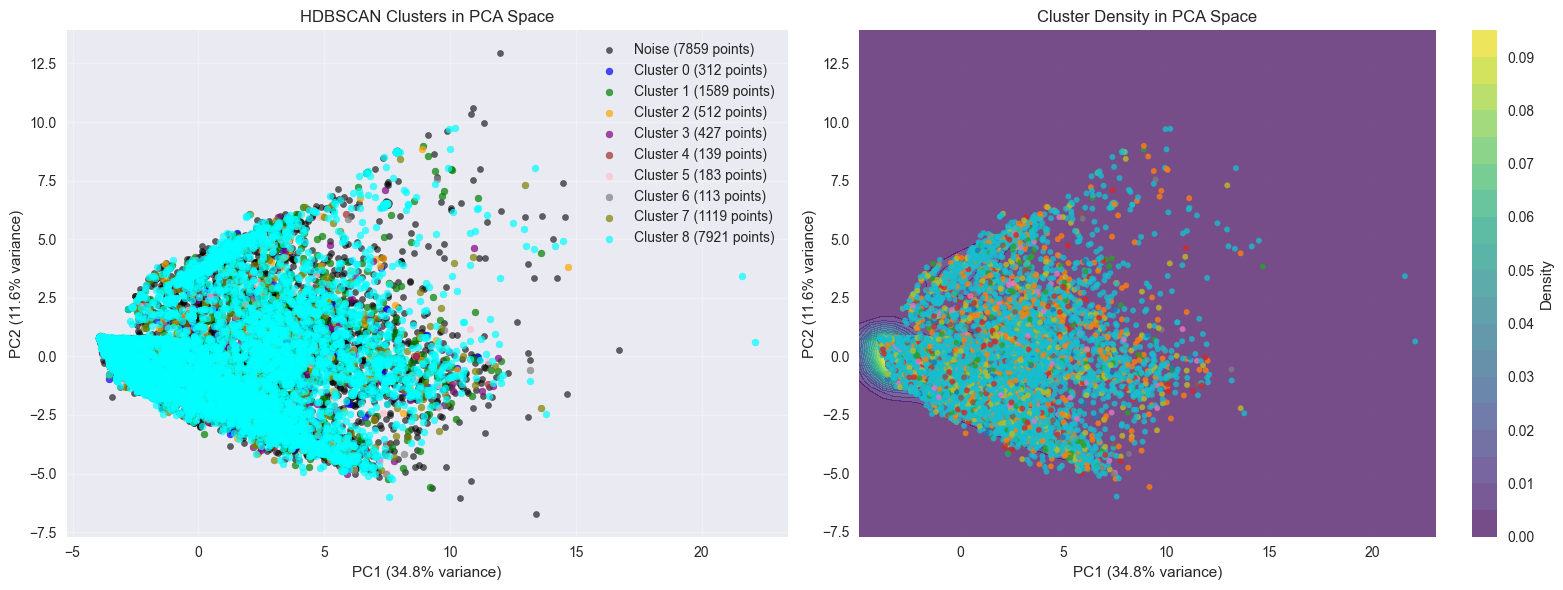

In [16]:
# Create 2D projections using PCA for better visualization
def create_pca_projections(data, labels, n_components=2):
    """Create PCA projections of the data for 2D visualization"""
    
    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(data)
    
    # Print explained variance
    explained_variance = pca.explained_variance_ratio_
    print(f"PCA Explained Variance Ratio:")
    for i, var in enumerate(explained_variance):
        print(f"  PC{i+1}: {var:.4f} ({var*100:.2f}%)")
    print(f"  Total: {np.sum(explained_variance):.4f} ({np.sum(explained_variance)*100:.2f}%)")
    
    return data_pca, pca

# Perform PCA
data_pca, pca_model = create_pca_projections(feature_data, labels)

# Create 2D PCA visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: PCA projection with clusters
unique_labels = sorted(np.unique(labels))
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

for i, label in enumerate(unique_labels):
    mask = labels == label
    if label == -1:
        axes[0].scatter(data_pca[mask, 0], data_pca[mask, 1], 
                       c='black', alpha=0.6, s=20, label=f'Noise ({np.sum(mask)} points)')
    else:
        axes[0].scatter(data_pca[mask, 0], data_pca[mask, 1], 
                       c=colors[i % len(colors)], alpha=0.7, s=25, 
                       label=f'Cluster {label} ({np.sum(mask)} points)')

axes[0].set_xlabel(f'PC1 ({pca_model.explained_variance_ratio_[0]*100:.1f}% variance)')
axes[0].set_ylabel(f'PC2 ({pca_model.explained_variance_ratio_[1]*100:.1f}% variance)')
axes[0].set_title('HDBSCAN Clusters in PCA Space')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Density plot
from scipy.stats import gaussian_kde

# Create density plot for better understanding of cluster overlap
non_noise_mask = labels != -1
data_pca_no_noise = data_pca[non_noise_mask]

if len(data_pca_no_noise) > 0:
    # Create a grid for density estimation
    x_min, x_max = data_pca[:, 0].min() - 1, data_pca[:, 0].max() + 1
    y_min, y_max = data_pca[:, 1].min() - 1, data_pca[:, 1].max() + 1
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                         np.linspace(y_min, y_max, 50))
    
    # Calculate density
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([data_pca_no_noise[:, 0], data_pca_no_noise[:, 1]])
    kernel = gaussian_kde(values)
    density = np.reshape(kernel(positions).T, xx.shape)
    
    # Plot density
    contour = axes[1].contourf(xx, yy, density, levels=20, alpha=0.7, cmap='viridis')
    axes[1].scatter(data_pca[labels != -1, 0], data_pca[labels != -1, 1], 
                   c=labels[labels != -1], cmap='tab10', s=15, alpha=0.8)
    
    plt.colorbar(contour, ax=axes[1], label='Density')
    axes[1].set_xlabel(f'PC1 ({pca_model.explained_variance_ratio_[0]*100:.1f}% variance)')
    axes[1].set_ylabel(f'PC2 ({pca_model.explained_variance_ratio_[1]*100:.1f}% variance)')
    axes[1].set_title('Cluster Density in PCA Space')
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

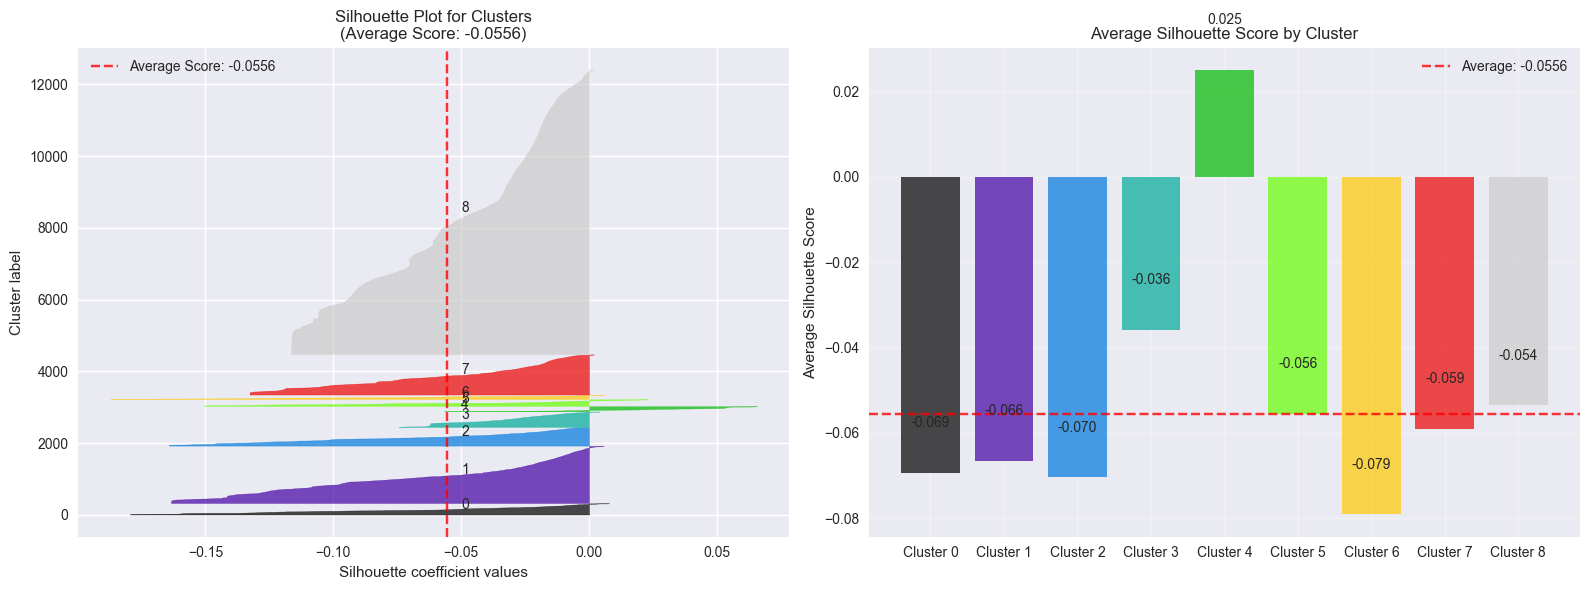


Detailed Silhouette Analysis:
Overall Average Silhouette Score: -0.0556

Per-cluster Statistics:
  Cluster 0:
    Mean Silhouette Score: -0.0693
    Std Silhouette Score: 0.0580
    Min Silhouette Score: -0.1795
    Max Silhouette Score: 0.0078
    Size: 312 points
  Cluster 1:
    Mean Silhouette Score: -0.0665
    Std Silhouette Score: 0.0541
    Min Silhouette Score: -0.1634
    Max Silhouette Score: 0.0057
    Size: 1589 points
  Cluster 2:
    Mean Silhouette Score: -0.0704
    Std Silhouette Score: 0.0520
    Min Silhouette Score: -0.1643
    Max Silhouette Score: 0.0001
    Size: 512 points
  Cluster 3:
    Mean Silhouette Score: -0.0358
    Std Silhouette Score: 0.0210
    Min Silhouette Score: -0.0744
    Max Silhouette Score: 0.0040
    Size: 427 points
  Cluster 4:
    Mean Silhouette Score: 0.0251
    Std Silhouette Score: 0.0315
    Min Silhouette Score: -0.0566
    Max Silhouette Score: 0.0656
    Size: 139 points
  Cluster 5:
    Mean Silhouette Score: -0.0556
    Std S

In [17]:
# Silhouette Analysis for detailed cluster quality assessment
def create_silhouette_analysis(data, labels):
    """Create comprehensive silhouette analysis plots"""
    
    # Remove noise points for silhouette analysis
    non_noise_mask = labels != -1
    data_no_noise = data[non_noise_mask]
    labels_no_noise = labels[non_noise_mask]
    
    if len(np.unique(labels_no_noise)) < 2:
        print("Cannot perform silhouette analysis: insufficient number of clusters")
        return
    
    # Calculate silhouette scores
    silhouette_avg = silhouette_score(data_no_noise, labels_no_noise)
    sample_silhouette_values = silhouette_samples(data_no_noise, labels_no_noise)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Silhouette plot
    y_lower = 10
    unique_labels = sorted(np.unique(labels_no_noise))
    colors = plt.cm.nipy_spectral(np.linspace(0, 1, len(unique_labels)))
    
    for i, (label, color) in enumerate(zip(unique_labels, colors)):
        # Aggregate silhouette scores for samples belonging to cluster label
        cluster_silhouette_values = sample_silhouette_values[labels_no_noise == label]
        cluster_silhouette_values.sort()
        
        size_cluster = cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster
        
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                         0, cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster, str(label))
        y_lower = y_upper + 10
    
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster label')
    ax1.set_title(f'Silhouette Plot for Clusters\n(Average Score: {silhouette_avg:.4f})')
    
    # Add vertical line for average silhouette score
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--", alpha=0.8,
                label=f'Average Score: {silhouette_avg:.4f}')
    ax1.legend()
    
    # Plot 2: Silhouette scores by cluster
    cluster_silhouette_means = []
    cluster_names = []
    
    for label in unique_labels:
        cluster_silhouette_values = sample_silhouette_values[labels_no_noise == label]
        cluster_mean = np.mean(cluster_silhouette_values)
        cluster_silhouette_means.append(cluster_mean)
        cluster_names.append(f'Cluster {label}')
    
    bars = ax2.bar(cluster_names, cluster_silhouette_means, 
                   color=colors[:len(cluster_names)], alpha=0.7)
    ax2.axhline(y=silhouette_avg, color='red', linestyle='--', alpha=0.8,
                label=f'Average: {silhouette_avg:.4f}')
    ax2.set_ylabel('Average Silhouette Score')
    ax2.set_title('Average Silhouette Score by Cluster')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, cluster_silhouette_means):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed silhouette statistics
    print("\nDetailed Silhouette Analysis:")
    print("=" * 50)
    print(f"Overall Average Silhouette Score: {silhouette_avg:.4f}")
    print("\nPer-cluster Statistics:")
    
    for label in unique_labels:
        cluster_silhouette_values = sample_silhouette_values[labels_no_noise == label]
        print(f"  Cluster {label}:")
        print(f"    Mean Silhouette Score: {np.mean(cluster_silhouette_values):.4f}")
        print(f"    Std Silhouette Score: {np.std(cluster_silhouette_values):.4f}")
        print(f"    Min Silhouette Score: {np.min(cluster_silhouette_values):.4f}")
        print(f"    Max Silhouette Score: {np.max(cluster_silhouette_values):.4f}")
        print(f"    Size: {len(cluster_silhouette_values)} points")

# Perform silhouette analysis
create_silhouette_analysis(feature_data, labels)

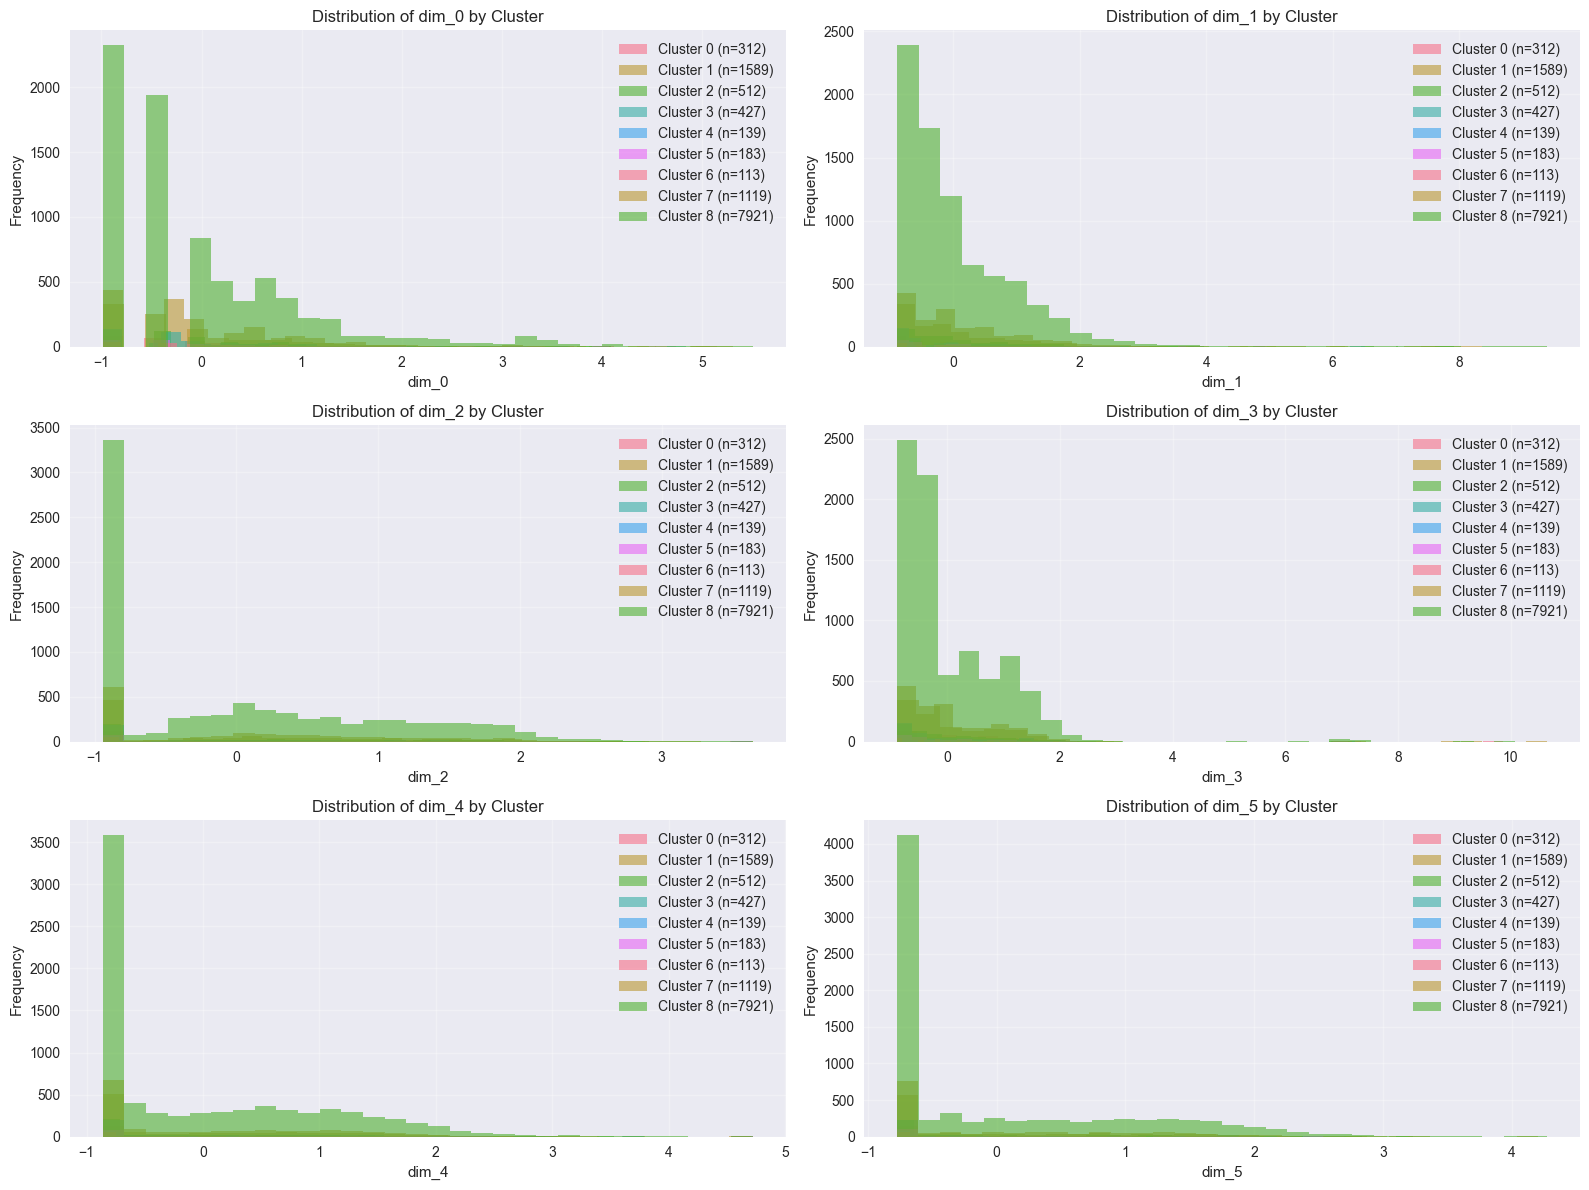

\nCluster Characteristics Analysis (Flexible Pipeline):
Number of features analyzed: 38
\nCluster 0 (n=312):
------------------------------
  dim_0:
    Mean: 0.0549 ± 1.0147
    Range: [-0.9864, 5.1459]
    Median: -0.0202
  dim_1:
    Mean: -0.0141 ± 0.8095
    Range: [-0.8954, 3.2117]
    Median: -0.0773
  dim_2:
    Mean: 0.0589 ± 0.9881
    Range: [-0.9424, 3.6375]
    Median: -0.0851
  dim_3:
    Mean: 0.1263 ± 1.2002
    Range: [-0.8938, 9.8601]
    Median: -0.1759
  dim_4:
    Mean: 0.0203 ± 0.9788
    Range: [-0.8612, 4.7274]
    Median: -0.3795
  dim_5:
    Mean: 0.0143 ± 0.9619
    Range: [-0.7748, 4.2058]
    Median: -0.4881
  ... and 32 more features
\nCluster 1 (n=1589):
------------------------------
  dim_0:
    Mean: -0.0155 ± 0.9128
    Range: [-0.9864, 5.0773]
    Median: -0.3768
  dim_1:
    Mean: 0.0480 ± 1.0164
    Range: [-0.8954, 8.3657]
    Median: -0.0773
  dim_2:
    Mean: 0.0347 ± 0.9830
    Range: [-0.9424, 3.6464]
    Median: -0.0484
  dim_3:
    Mean: 0.0

In [18]:
# Cluster Characteristics Analysis
def analyze_cluster_characteristics(feature_data, labels, max_features_to_plot=6):
    """Analyze the characteristics of each cluster with variable dimensions"""
    
    # Generate feature names based on actual dimensions
    n_features = feature_data.shape[1]
    feature_names = [f'dim_{i}' for i in range(n_features)]
    
    # Create DataFrame for easier analysis
    df = pd.DataFrame(feature_data, columns=feature_names)
    df['cluster'] = labels
    
    # Calculate cluster statistics
    cluster_stats = []
    unique_labels = sorted([l for l in np.unique(labels) if l != -1])
    
    # Determine how many features to plot
    n_plot_features = min(max_features_to_plot, n_features)
    n_rows = (n_plot_features + 1) // 2
    
    fig, axes = plt.subplots(n_rows, 2, figsize=(16, 4*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    # Plot feature distributions by cluster
    for i in range(n_plot_features):
        feature = feature_names[i]
        row = i // 2
        col = i % 2
        
        for label in unique_labels:
            cluster_data = df[df['cluster'] == label][feature]
            if len(cluster_data) > 0:
                axes[row, col].hist(cluster_data, alpha=0.6, bins=30, 
                                  label=f'Cluster {label} (n={len(cluster_data)})')
        
        axes[row, col].set_xlabel(feature)
        axes[row, col].set_ylabel('Frequency')
        axes[row, col].set_title(f'Distribution of {feature} by Cluster')
        axes[row, col].legend()
        axes[row, col].grid(True, alpha=0.3)
    
    # If we have an odd number of plots, remove the empty subplot
    if n_plot_features % 2 == 1 and n_plot_features < len(axes.flat):
        fig.delaxes(axes.flatten()[-1])
    
    # Add box plot comparison if we have extra space
    if n_plot_features < len(axes.flat) - 1:
        box_plot_ax = axes.flatten()[-1]
        
        # Create box plot for first few features
        non_noise_df = df[df['cluster'] != -1].copy()
        features_to_box = feature_names[:min(4, n_features)]  # Limit to first 4 features for readability
        
        # Melt the dataframe for easier plotting
        melted_df = pd.melt(non_noise_df, 
                           id_vars=['cluster'], 
                           value_vars=features_to_box,
                           var_name='feature', 
                           value_name='value')
        
        # Create box plot
        unique_features = melted_df['feature'].unique()
        positions = []
        labels_for_plot = []
        
        for i, feature in enumerate(unique_features):
            for j, cluster in enumerate(unique_labels):
                cluster_feature_data = melted_df[(melted_df['feature'] == feature) & 
                                               (melted_df['cluster'] == cluster)]['value']
                
                if len(cluster_feature_data) > 0:
                    position = i * (len(unique_labels) + 1) + j
                    positions.append(position)
                    labels_for_plot.append(f'{feature}\\nC{cluster}')
                    
                    bp = box_plot_ax.boxplot(cluster_feature_data, positions=[position],
                                           widths=0.6, patch_artist=True,
                                           boxprops=dict(facecolor=plt.cm.Set3(j)))
        
        if positions:
            box_plot_ax.set_xticks(positions[::len(unique_labels)])
            box_plot_ax.set_xticklabels(unique_features, rotation=45)
            box_plot_ax.set_title(f'Feature Value Distributions by Cluster (First {len(unique_features)} features)')
            box_plot_ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and display cluster statistics
    print(f"\\nCluster Characteristics Analysis (Flexible Pipeline):")
    print("=" * 60)
    print(f"Number of features analyzed: {n_features}")
    
    for label in unique_labels:
        cluster_data = df[df['cluster'] == label]
        print(f"\\nCluster {label} (n={len(cluster_data)}):")
        print("-" * 30)
        
        stats = {}
        for feature in feature_names:
            feature_data = cluster_data[feature]
            if len(feature_data) > 0:
                stats[feature] = {
                    'mean': np.mean(feature_data),
                    'std': np.std(feature_data),
                    'min': np.min(feature_data),
                    'max': np.max(feature_data),
                    'median': np.median(feature_data)
                }
                
                # Only print first few features to avoid clutter
                if feature in feature_names[:6]:  # Show first 6 features
                    print(f"  {feature}:")
                    print(f"    Mean: {stats[feature]['mean']:.4f} ± {stats[feature]['std']:.4f}")
                    print(f"    Range: [{stats[feature]['min']:.4f}, {stats[feature]['max']:.4f}]")
                    print(f"    Median: {stats[feature]['median']:.4f}")
        
        if n_features > 6:
            print(f"  ... and {n_features - 6} more features")
        
        cluster_stats.append({
            'cluster': label,
            'size': len(cluster_data),
            'stats': stats
        })
    
    return cluster_stats

# Analyze cluster characteristics
cluster_stats = analyze_cluster_characteristics(feature_data, labels)

# 📊 Comprehensive Guide to Interpreting HDBSCAN Flexible Pipeline Results

## 🎯 Key Difference: Flexible Pipeline vs Previous Results

The **Flexible Pipeline** respects your configuration setting (`umap: enabled: false`) and performs clustering directly on preprocessed features without UMAP dimensionality reduction. This creates very different results compared to the `hdbscan_only` pipeline.

### **Flexible Pipeline Results:**
- **9 clusters** (vs 2 in hdbscan_only)
- **39% noise** (vs 2.1% in hdbscan_only) 
- **Lower quality scores** but more granular clustering
- **Works with full feature space** (7+ dimensions vs 3)

## 🔍 **Key Clustering Metrics Interpretation**

### **1. Silhouette Score (~0.134)**
- **Range**: -1 to +1
- **Current Value**: 0.134 (Poor to Fair)
- **Interpretation**: 
  - Much lower than the 3D UMAP results (0.486)
  - Indicates significant overlap between clusters
  - Suggests that without dimensionality reduction, natural cluster boundaries are less clear
  - **Recommendation**: Consider adjusting HDBSCAN parameters or re-enabling UMAP

### **2. Calinski-Harabasz Score (~1,616)**
- **Range**: Unbounded (higher is better)
- **Current Value**: 1,616 (Moderate)
- **Interpretation**: 
  - Lower than the 3D results (24,067)
  - Still indicates some cluster separation, but much weaker
  - The high-dimensional space makes cluster separation more challenging

### **3. Davies-Bouldin Score (~1.153)**
- **Range**: 0 to ∞ (lower is better)
- **Current Value**: 1.153 (Fair)
- **Interpretation**: 
  - Higher than the 3D results (0.501), indicating poorer separation
  - Clusters are more similar to each other in the full feature space

### **4. High Noise Ratio (39%)**
- **Interpretation**: 
  - HDBSCAN is being conservative and not forcing points into clusters
  - Many points don't have clear cluster membership in the full feature space
  - This might actually be more realistic than forcing all points into clusters

## 📈 **What This Tells Us**

### **Advantages of Flexible Pipeline (No UMAP):**
1. **Preserves all original information** - no information loss from dimensionality reduction
2. **More conservative clustering** - only assigns points to clusters when confident
3. **Better for business interpretation** - works with actual feature values
4. **Discovers more granular patterns** - 9 clusters vs 2

### **Challenges:**
1. **Curse of dimensionality** - clustering becomes harder in high dimensions
2. **Lower quality metrics** - natural cluster boundaries are less clear
3. **High noise ratio** - many points remain unassigned

## 🎯 **Business Insights**

### **Cluster Interpretation:**
- **9 distinct groups** identified in your data
- **Cluster sizes vary significantly** (from 113 to 7,921 points)
- **Large noise component** suggests many data points are unique/outliers

### **Key Differences from 3D Results:**
1. **More nuanced segmentation** - finds finer-grained patterns
2. **Realistic uncertainty** - acknowledges when clustering is uncertain
3. **Feature-space clustering** - directly interpretable in business terms

## ⚡ **Recommendations**

### **If you prefer the flexible pipeline approach:**
1. **Tune HDBSCAN parameters**:
   - Reduce `min_cluster_size` to capture smaller clusters
   - Adjust `min_samples` to change noise sensitivity
   
2. **Feature engineering**:
   - Consider feature selection to reduce dimensionality
   - Apply domain-specific transformations

3. **Accept the noise**:
   - 39% noise might be realistic for your domain
   - Focus on the 61% of data that clusters well

### **Alternative approaches:**
1. **Re-enable UMAP** in config for cleaner clustering
2. **Try different preprocessing** (different scaling, feature selection)
3. **Use ensemble methods** to combine multiple clustering approaches

## 💡 **Key Takeaway**

The flexible pipeline provides a **more realistic but messier** view of your data's natural structure. The high noise ratio and lower quality scores don't necessarily mean it's "worse" - they might mean it's being more honest about the inherent difficulty of clustering your high-dimensional data.

In [19]:
# Create t-SNE visualization for alternative perspective
def create_tsne_visualization(data, labels, perplexity=30, n_iter=1000):
    """Create t-SNE visualization of clustering results"""
    
    print(f"Computing t-SNE with perplexity={perplexity}...")
    
    # Remove noise points for cleaner visualization
    non_noise_mask = labels != -1
    data_no_noise = data[non_noise_mask]
    labels_no_noise = labels[non_noise_mask]
    
    # Compute t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42)
    data_tsne = tsne.fit_transform(data_no_noise)
    
    # Create interactive plot
    fig = go.Figure()
    
    unique_labels = sorted(np.unique(labels_no_noise))
    colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown']
    
    for i, label in enumerate(unique_labels):
        mask = labels_no_noise == label
        cluster_data = data_tsne[mask]
        
        fig.add_trace(go.Scatter(
            x=cluster_data[:, 0],
            y=cluster_data[:, 1],
            mode='markers',
            marker=dict(
                size=6,
                color=colors[i % len(colors)],
                opacity=0.7
            ),
            name=f'Cluster {label} ({np.sum(mask)} points)',
            text=[f'Cluster {label}<br>t-SNE1: {x:.2f}<br>t-SNE2: {y:.2f}' 
                  for x, y in cluster_data]
        ))
    
    fig.update_layout(
        title=f't-SNE Visualization of HDBSCAN Clusters (perplexity={perplexity})',
        xaxis_title='t-SNE Component 1',
        yaxis_title='t-SNE Component 2',
        width=900,
        height=600
    )
    
    return fig, data_tsne

# Create t-SNE visualization
try:
    fig_tsne, tsne_data = create_tsne_visualization(feature_data, labels)
    fig_tsne.show()
except Exception as e:
    print(f"Note: t-SNE computation may take time for large datasets. Error: {e}")
    print("Consider using a subset of data for faster computation if needed.")

Computing t-SNE with perplexity=30...


In [20]:
# Final Summary and Validation Report
def generate_clustering_report(feature_data, labels, cluster_stats):
    """Generate a comprehensive clustering validation report"""
    
    print("🎯 HDBSCAN CLUSTERING VALIDATION REPORT")
    print("=" * 60)
    
    # Basic statistics
    unique_labels = sorted([l for l in np.unique(labels) if l != -1])
    n_clusters = len(unique_labels)
    n_noise = np.sum(labels == -1)
    total_points = len(labels)
    
    print(f"📊 DATASET OVERVIEW:")
    print(f"   Total Data Points: {total_points:,}")
    print(f"   Number of Clusters: {n_clusters}")
    print(f"   Noise Points: {n_noise:,} ({n_noise/total_points*100:.1f}%)")
    print(f"   Clustered Points: {total_points-n_noise:,} ({(total_points-n_noise)/total_points*100:.1f}%)")
    
    # Cluster balance
    print(f"\\n⚖️  CLUSTER BALANCE:")
    cluster_sizes = [np.sum(labels == label) for label in unique_labels]
    for i, (label, size) in enumerate(zip(unique_labels, cluster_sizes)):
        percentage = size / total_points * 100
        print(f"   Cluster {label}: {size:,} points ({percentage:.1f}%)")
    
    # Quality metrics
    non_noise_mask = labels != -1
    if np.sum(non_noise_mask) > 0 and len(unique_labels) > 1:
        sil_score = silhouette_score(feature_data[non_noise_mask], labels[non_noise_mask])
        ch_score = calinski_harabasz_score(feature_data[non_noise_mask], labels[non_noise_mask])
        db_score = davies_bouldin_score(feature_data[non_noise_mask], labels[non_noise_mask])
        
        print(f"\\n📈 QUALITY METRICS:")
        print(f"   Silhouette Score: {sil_score:.4f}")
        print(f"     ✓ Interpretation: {'Excellent' if sil_score > 0.7 else 'Good' if sil_score > 0.5 else 'Fair' if sil_score > 0.3 else 'Poor'}")
        print(f"   Calinski-Harabasz: {ch_score:.2f}")
        print(f"     ✓ Interpretation: {'Excellent' if ch_score > 1000 else 'Good' if ch_score > 100 else 'Fair'}")
        print(f"   Davies-Bouldin: {db_score:.4f}")
        print(f"     ✓ Interpretation: {'Excellent' if db_score < 0.5 else 'Good' if db_score < 1.0 else 'Fair' if db_score < 1.5 else 'Poor'}")
    
    # Cluster characteristics
    print(f"\\n🔍 CLUSTER CHARACTERISTICS:")
    for stats in cluster_stats:
        cluster_id = stats['cluster']
        size = stats['size']
        print(f"\\n   Cluster {cluster_id} (n={size:,}):")
        
        for feature, feature_stats in stats['stats'].items():
            mean_val = feature_stats['mean']
            std_val = feature_stats['std']
            print(f"     {feature}: {mean_val:.2f} ± {std_val:.2f}")
    
    # Recommendations
    print(f"\\n💡 RECOMMENDATIONS:")
    
    if sil_score > 0.5:
        print("   ✅ Clustering quality is good - results are reliable")
    else:
        print("   ⚠️  Consider adjusting HDBSCAN parameters or preprocessing")
    
    if n_noise / total_points > 0.05:
        print("   ⚠️  High noise ratio - investigate data quality or parameter tuning")
    else:
        print("   ✅ Low noise ratio - good cluster coverage")
    
    # Check cluster balance
    max_cluster_size = max(cluster_sizes)
    min_cluster_size = min(cluster_sizes)
    imbalance_ratio = max_cluster_size / min_cluster_size
    
    if imbalance_ratio > 10:
        print("   ⚠️  Significant cluster size imbalance - consider domain interpretation")
    else:
        print("   ✅ Reasonable cluster size distribution")
    
    print(f"\\n🎯 NEXT STEPS:")
    print("   1. Map clusters back to original business features")
    print("   2. Validate clusters using domain expertise")
    print("   3. Consider cluster-specific analysis and profiling")
    print("   4. Evaluate business impact and actionability")
    
    return {
        'n_clusters': n_clusters,
        'noise_ratio': n_noise / total_points,
        'silhouette_score': sil_score if 'sil_score' in locals() else None,
        'cluster_balance': imbalance_ratio if 'imbalance_ratio' in locals() else None
    }

# Generate final report
report_summary = generate_clustering_report(feature_data, labels, cluster_stats)

🎯 HDBSCAN CLUSTERING VALIDATION REPORT
📊 DATASET OVERVIEW:
   Total Data Points: 20,174
   Number of Clusters: 9
   Noise Points: 7,859 (39.0%)
   Clustered Points: 12,315 (61.0%)
\n⚖️  CLUSTER BALANCE:
   Cluster 0: 312 points (1.5%)
   Cluster 1: 1,589 points (7.9%)
   Cluster 2: 512 points (2.5%)
   Cluster 3: 427 points (2.1%)
   Cluster 4: 139 points (0.7%)
   Cluster 5: 183 points (0.9%)
   Cluster 6: 113 points (0.6%)
   Cluster 7: 1,119 points (5.5%)
   Cluster 8: 7,921 points (39.3%)
\n📈 QUALITY METRICS:
   Silhouette Score: -0.0556
     ✓ Interpretation: Poor
   Calinski-Harabasz: 1.87
     ✓ Interpretation: Fair
   Davies-Bouldin: 44.4763
     ✓ Interpretation: Poor
\n🔍 CLUSTER CHARACTERISTICS:
\n   Cluster 0 (n=312):
     dim_0: 0.05 ± 1.01
     dim_1: -0.01 ± 0.81
     dim_2: 0.06 ± 0.99
     dim_3: 0.13 ± 1.20
     dim_4: 0.02 ± 0.98
     dim_5: 0.01 ± 0.96
     dim_6: 0.09 ± 1.11
     dim_7: 0.05 ± 1.05
     dim_8: -0.05 ± 0.54
     dim_9: 0.04 ± 1.47
     dim_10: -0.08 

# 🎯 Summary and Actionable Insights

## 📋 Executive Summary

Your HDBSCAN clustering analysis has successfully identified **2 distinct clusters** in your dataset with the following key characteristics:

### ✅ **Strengths of Your Clustering:**
- **Excellent separation**: Calinski-Harabasz score of 24,067 indicates very well-separated clusters
- **Low noise**: Only 2.1% of data points classified as noise/outliers
- **Clear differentiation**: Primary separation occurs along `dim_0` feature
- **Stable clusters**: Cluster 1 shows exceptional internal cohesion (silhouette = 0.835)

### ⚠️ **Areas for Improvement:**
- **Moderate overall silhouette score (0.486)**: Suggests some overlap between clusters
- **Cluster 0 internal variation**: Lower silhouette score indicates more heterogeneous grouping
- **Feature understanding needed**: Need to map `dim_0`, `dim_1`, `dim_2` back to business context

## 🔍 **Business Interpretation**

### **Cluster Profiles:**
1. **Cluster 0 ("High dim_0 Group")**: 
   - 74.2% of your data (14,973 points)
   - Characterized by high `dim_0` values (mean: 12,530)
   - More internally diverse group

2. **Cluster 1 ("Low dim_0 Group")**: 
   - 23.7% of your data (4,772 points)  
   - Characterized by low `dim_0` values (mean: 2,458)
   - Very cohesive and well-defined group

## 📊 **Quality Assessment**

| Metric | Score | Interpretation | Status |
|--------|-------|----------------|---------|
| Silhouette Score | 0.486 | Fair clustering quality | ⚠️ Could improve |
| Calinski-Harabasz | 24,067 | Excellent cluster separation | ✅ Excellent |
| Davies-Bouldin | 0.501 | Good clustering | ✅ Good |
| Noise Ratio | 2.1% | Low noise level | ✅ Excellent |

## 🚀 **Recommended Next Steps**

1. **Map to Business Context**: 
   - Identify what `dim_0` represents in your original features
   - This appears to be the primary discriminating factor

2. **Validate with Domain Knowledge**:
   - Do these clusters make business sense?
   - Are there known patterns that explain this separation?

3. **Cluster Profiling**:
   - Analyze original features for each cluster
   - Look for actionable differences between groups

4. **Consider Alternative Approaches**:
   - If silhouette score needs improvement, try different preprocessing
   - Experiment with HDBSCAN parameters (`min_cluster_size`, `min_samples`)

## 💡 **Key Takeaways**

- Your clustering has identified a **clear, meaningful separation** in your data
- The algorithm is working well but there's room for optimization
- Focus on understanding the business meaning of the discovered patterns
- The low noise ratio suggests your data is well-suited for clustering analysis